In [25]:
!pip install numpyro

                                              0.0/356.1 kB ? eta -:--:--
     --------------                         133.1/356.1 kB 4.0 MB/s eta 0:00:01
     -------------------------------------- 356.1/356.1 kB 7.4 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.1.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


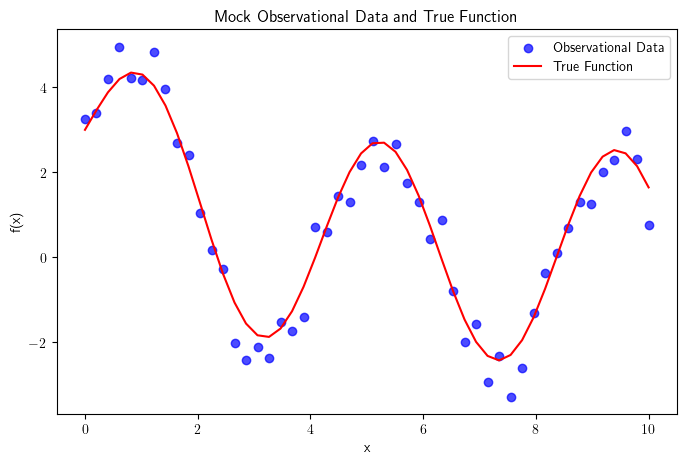

100%|██████████| 5000/5000 [00:04<00:00, 1128.32it/s]


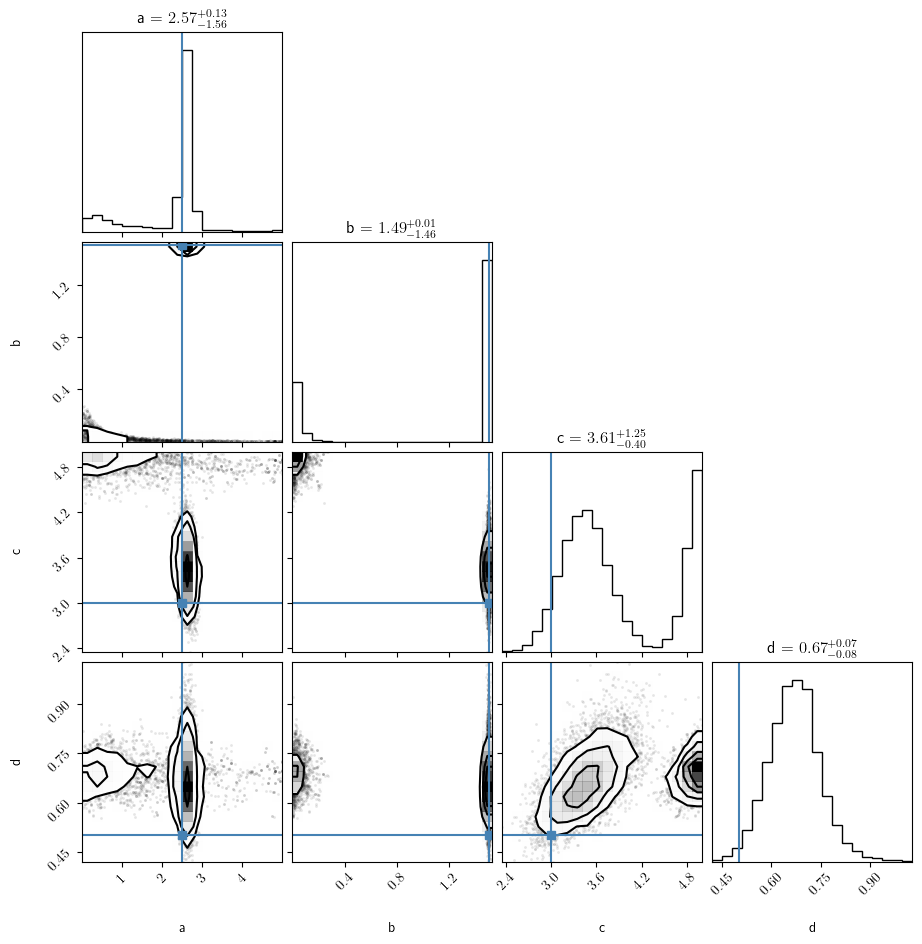

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner


def g(x, a, b):
    return a * np.sin(b * x)

def h(x, c, d):
    return c * np.exp(-d * x)

# Define the combined function f(x)
def f(x, a, b, c, d):
    return g(x, a, b) + h(x, c, d)

# Generate mock observational data
np.random.seed(42)
true_params = [2.5, 1.5, 3.0, 0.5]  # a, b, c, d
x_obs = np.linspace(0, 10, 50)
y_true = f(x_obs, *true_params)
noise = 0.5 * np.random.randn(len(x_obs))
y_obs = y_true + noise

# Plot the mock data
plt.figure(figsize=(8, 5))
plt.scatter(x_obs, y_obs, color="blue", label="Observational Data", alpha=0.7)
plt.plot(x_obs, y_true, color="red", label="True Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.title("Mock Observational Data and True Function")
plt.show()

# Define the log-likelihood function
def log_likelihood(theta, x, y, yerr):
    a, b, c, d = theta
    model = f(x, a, b, c, d)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Define the log-prior function
def log_prior(theta):
    a, b, c, d = theta
    if 0 < a < 5 and 0 < b < 3 and 0 < c < 5 and 0 < d < 2:
        return 0.0  # flat prior
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Initialize the MCMC sampler
ndim = 4  # Number of parameters
nwalkers = 32  # Number of walkers
nsteps = 5000  # Number of steps

# Initial guess for parameters
initial = [2.0, 1.0, 2.0, 0.3]  # close to true params
pos = initial + 0.1 * np.random.randn(nwalkers, ndim)

# Observational noise
yerr = 0.5

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_obs, y_obs, yerr))

# Run the MCMC sampler
sampler.run_mcmc(pos, nsteps, progress=True);

# Flatten the chain and discard burn-in samples
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Make a corner plot
labels = ["a", "b", "c", "d"]
corner.corner(flat_samples, labels=labels, truths=true_params, show_titles=True)
plt.show()


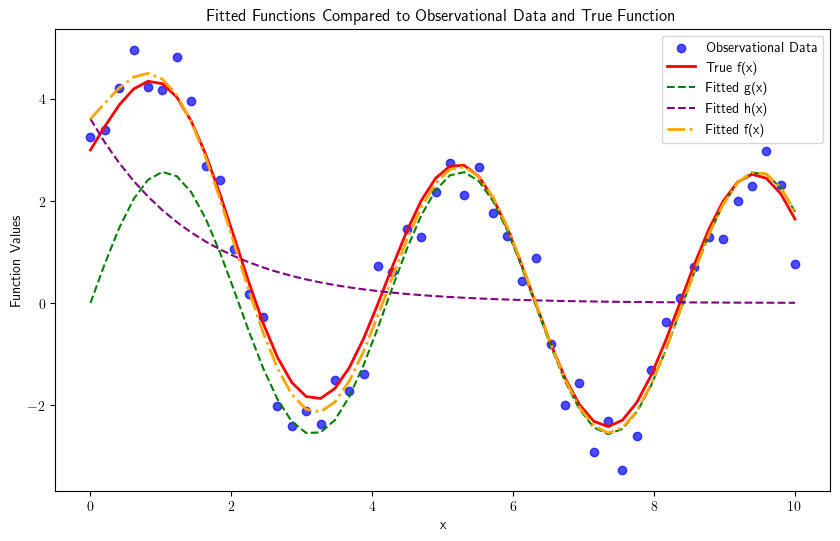

In [8]:
# Extract median values of parameters from MCMC samples
a_mcmc, b_mcmc, c_mcmc, d_mcmc = np.median(flat_samples, axis=0)

# Calculate fitted functions
f_fit = f(x_obs, a_mcmc, b_mcmc, c_mcmc, d_mcmc)
g_fit = g(x_obs, a_mcmc, b_mcmc)
h_fit = h(x_obs, c_mcmc, d_mcmc)

# Plot the true functions, observational data, and fitted functions
plt.figure(figsize=(10, 6))
plt.scatter(x_obs, y_obs, color="blue", label="Observational Data", alpha=0.7)
plt.plot(x_obs, y_true, color="red", label="True f(x)", linewidth=2)
plt.plot(x_obs, g_fit, color="green", linestyle="--", label="Fitted g(x)")
plt.plot(x_obs, h_fit, color="purple", linestyle="--", label="Fitted h(x)")
plt.plot(x_obs, f_fit, color="orange", linestyle="-.", label="Fitted f(x)", linewidth=2)
plt.xlabel("x")
plt.ylabel("Function Values")
plt.title("Fitted Functions Compared to Observational Data and True Function")
plt.legend()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv  # Modified Bessel functions of the first and second kinds

# Constants
G = 4.300e-6  # Gravitational constant in kpc (km/s)^2 / Msun

# Disk parameters
M_disk = 5e10  # Solar masses
R_d = 3  # Scale length in kpc

# Bulge parameters
M_bulge = 1e10  # Solar masses
a_bulge = 0.5  # Scale length in kpc

# Halo parameters
rho_0 = 0.01  # Central density in Msun / kpc^3
r_s = 10  # Scale radius in kpc

# Radial range
r = np.linspace(0.1, 50, 500)  # Radial distance in kpc

# Disk rotation curve
y = r / (2 * R_d)
v_disk2 = (G * M_disk / R_d) * y**2 * (iv(0, y) * kv(0, y) - iv(1, y) * kv(1, y))
v_disk = np.sqrt(np.maximum(v_disk2, 0))

# Bulge rotation curve
v_bulge2 = G * M_bulge / (r + a_bulge)
v_bulge = np.sqrt(np.maximum(v_bulge2, 0))

# Halo rotation curve
def halo_mass(r):
    return 4 * np.pi * rho_0 * r_s**3 * (np.log(1 + r / r_s) - r / (r + r_s))

v_halo2 = G * halo_mass(r) / r
v_halo =100000* np.sqrt(np.maximum(v_halo2, 0))

# Total rotation curve
v_total = np.sqrt(v_disk**2 + v_bulge**2 + v_halo**2)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(r, v_disk, label="Disk", lw=2)
plt.plot(r, v_bulge, label="Bulge", lw=2)
plt.plot(r, v_halo, label="Halo", lw=2)
plt.plot(r, v_total, label="Total", lw=2, linestyle='--')

plt.xlabel("Radius (kpc)", fontsize=14)
plt.ylabel("Velocity (km/s)", fontsize=14)
plt.title("Theoretical Galaxy Rotation Curve", fontsize=16)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

plt.show()


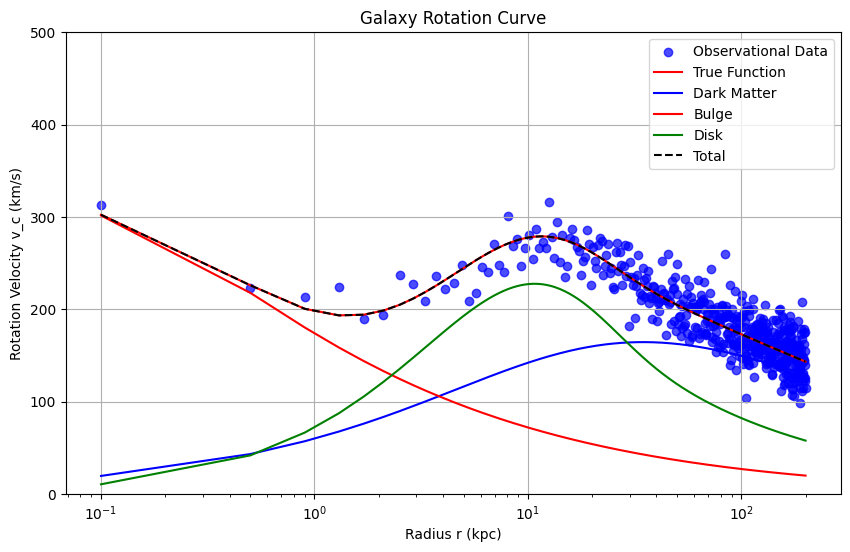

In [152]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import iv, kv  # Modified Bessel functions

# Constants
G = 4.302e-6  # Gravitational constant (kpc / M_sun * (km/s)^2)

# Dark Matter (DM) parameters
rho_DM_0 = np.exp(15.9)   # Central density (M_sun/kpc^3)
r_s = 16.0        # Scale radius (kpc)
R_0 = 8.0         # Solar galactocentric radius (kpc)

# Bulge parameters
rho_b0 = np.exp(29.5)     # Central bulge density (M_sun/kpc^3)
r_b = 0.03      # Bulge scale radius (kpc)

# Disk parameters
Sigma_0 = 200   # Surface density (M_sun/pc^2 -> converted later to kpc^2)
R_d = 5.0         # Scale radius (kpc)
z_d = 0.34        # Scale height (kpc)

# Define radii for calculation
r = np.linspace(0.1, 200, 500)  # Radii in kpc

# 1. Dark Matter Rotation Curve (v_DM)
def v_DM(r,rho_DM_0,r_s):
    M_DM = 4 * np.pi * rho_DM_0 *R_0* (R_0+r_s)**2 * (np.log((r + r_s) / r_s) - r / (r + r_s))
    return np.sqrt(G * M_DM / r)

# 2. Bulge Rotation Curve (v_bulge)
def v_bulge(r,rho_b0,r_b):
    M_b = 4 * np.pi * rho_b0 * r_b**3 * (np.arcsinh(r / r_b) - (r / r_b) / np.sqrt(1 + (r / r_b)**2))
    return np.sqrt(G * M_b / r)

# 3. Disk Rotation Curve (v_disk)
def v_disk(r,Sigma_0, R_d):
    # Convert surface density from pc^2 to kpc^2
    Sigma_0_kpc2 = Sigma_0 * 1e6
    v2_disk = (
        4 * np.pi * G * Sigma_0_kpc2 * R_d * (r / (2 * R_d))**2 * np.exp(R_0/ R_d) *
        (
            iv(0, r / (2 * R_d)) * kv(0, r / (2 * R_d)) -
            iv(1, r / (2 * R_d)) * kv(1, r / (2 * R_d))
        )
    )
    return np.sqrt(v2_disk)

# Calculate rotation curves
v_DM_vals = v_DM(r,rho_DM_0,r_s)
v_bulge_vals = v_bulge(r,rho_b0,r_b)
v_disk_vals = v_disk(r,Sigma_0, R_d)

# Total rotation curve

def v_total(r,rho_DM_0,r_s,rho_b0,r_b,Sigma_0, R_d):
    return np.sqrt(v_DM(r,rho_DM_0,r_s)**2 + v_bulge(r,rho_b0,r_b)**2 + v_disk(r,Sigma_0, R_d)**2)

# Generate mock observational data
np.random.seed(42)
true_params = [np.exp(15.9),16,np.exp(29.5),0.03,200,5]  # a, b, c, d
x_obs = np.linspace(0.1, 200, 500)
y_true = v_total(x_obs, *true_params)
noise = 20.5 * np.random.randn(len(x_obs))
y_obs = y_true + noise



# Plotting
plt.figure(figsize=(10, 6))



plt.scatter(x_obs, y_obs, color="blue", label="Observational Data", alpha=0.7)
plt.plot(x_obs, y_true, color="red", label="True Function")

plt.plot(r, v_DM_vals, label='Dark Matter', color='blue')
plt.plot(r, v_bulge_vals, label='Bulge', color='red')
plt.plot(r, v_disk_vals, label='Disk', color='green')
plt.plot(r, np.sqrt(v_DM_vals**2 + v_bulge_vals**2 + v_disk_vals**2), label='Total', color='black', linestyle='--')
plt.ylim(0,500)
plt.xscale("log")
plt.xlabel('Radius r (kpc)')
plt.ylabel('Rotation Velocity v_c (km/s)')
plt.title('Galaxy Rotation Curve')
plt.legend()
plt.grid()
plt.show()

  0%|          | 0/5000 [00:00<?, ?it/s]c:\Python311\Lib\site-packages\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [01:56<00:00, 42.93it/s]


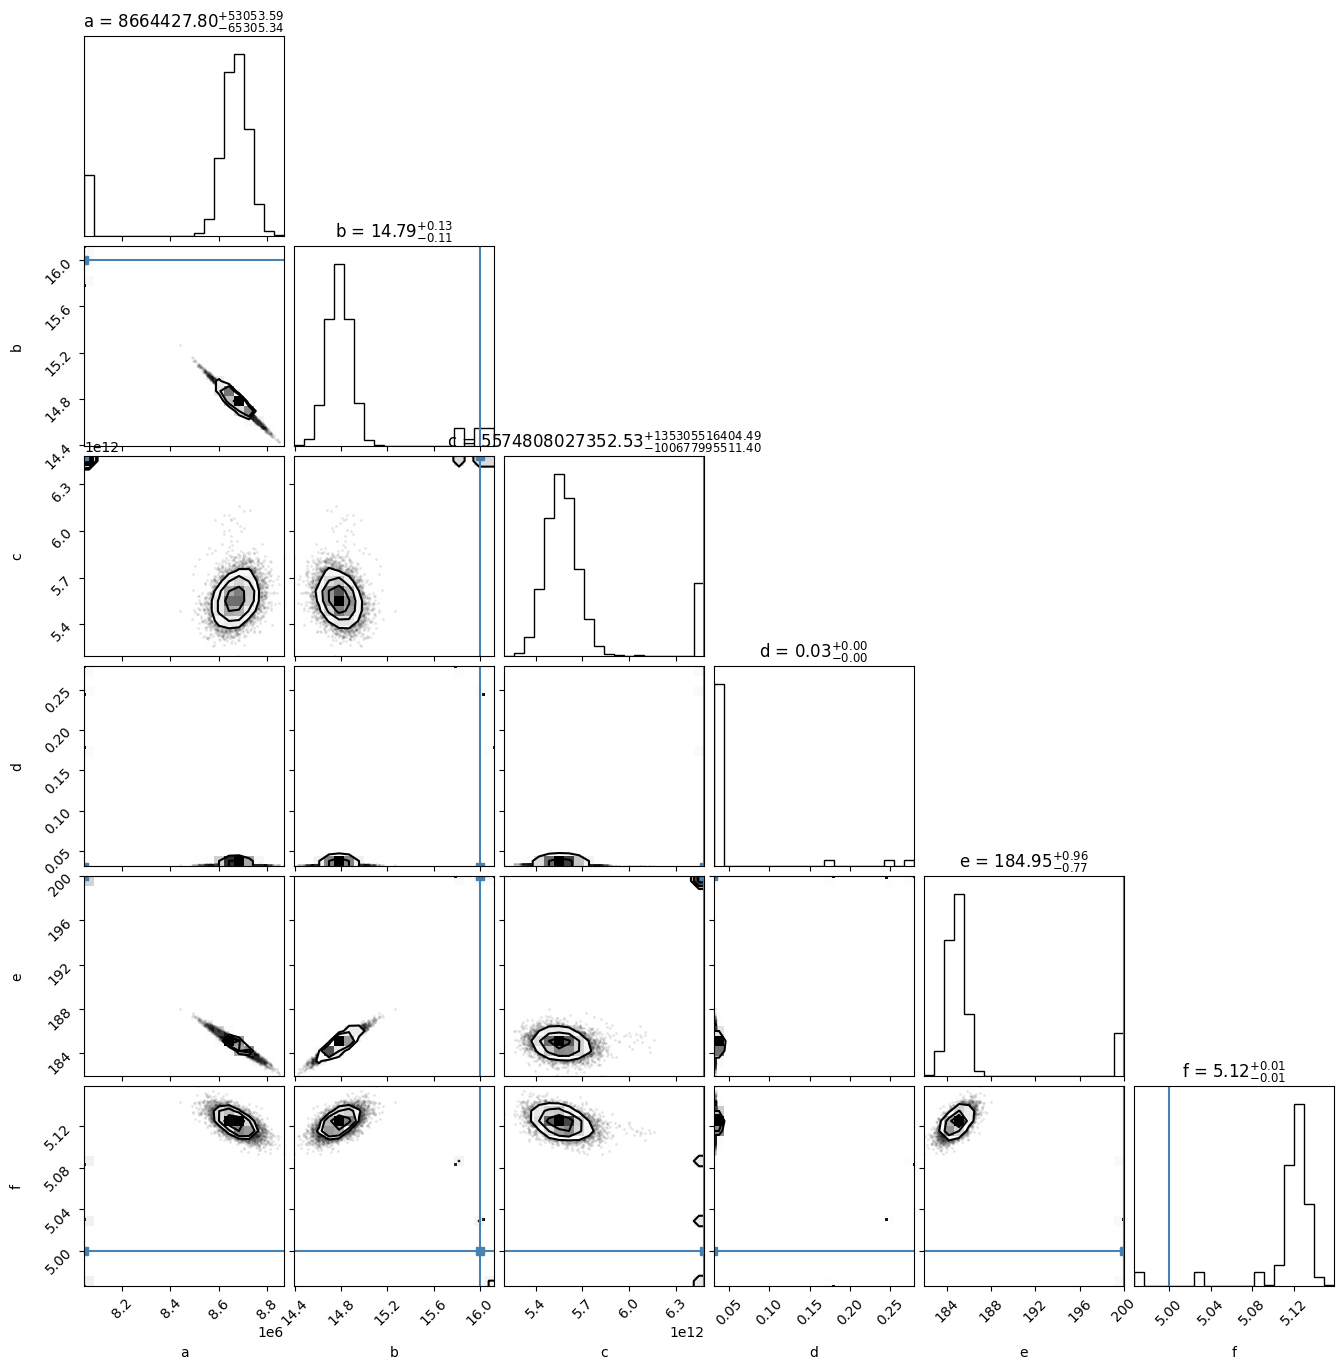

In [138]:


import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
# Define the log-likelihood function
def log_likelihood(theta, x, y, yerr):
    rho_DM_0,r_s,rho_b0,r_b,Sigma_0, R_d = theta
    model = v_total(x, rho_DM_0,r_s,rho_b0,r_b,Sigma_0, R_d)
    return -0.5 * np.sum(((y - model) / yerr) ** 2)

# Define the log-prior function
def log_prior(theta):
    rho_DM_0,r_s,rho_b0,r_b,Sigma_0, R_d = theta
    if np.exp(14) < rho_DM_0 < np.exp(16) and 10<r_s < 20 and np.exp(29.1) < rho_b0 < np.exp(29.8) and 0.01 < r_b < 0.05 and 150 < Sigma_0 < 250 and 3< R_d < 56:
        return 0.0  # flat prior
    return -np.inf

# Define the log-posterior function
def log_posterior(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

# Initialize the MCMC sampler
ndim = 6  # Number of parameters
nwalkers = 32  # Number of walkers
nsteps = 5000  # Number of steps

# Initial guess for parameters
initial = [np.exp(15.9),16,np.exp(29.5),0.03,200,5]  # close to true params
pos = initial + 0.1 * np.random.randn(nwalkers, ndim)

# Observational noise
yerr = 0.5

# Set up the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(x_obs, y_obs, yerr))

# Run the MCMC sampler
sampler.run_mcmc(pos, nsteps, progress=True)

# Flatten the chain and discard burn-in samples
flat_samples = sampler.get_chain(discard=1000, thin=15, flat=True)

# Make a corner plot
labels = ["a", "b", "c", "d","e","f"]
corner.corner(flat_samples, labels=labels, truths=true_params, show_titles=True)
plt.show()


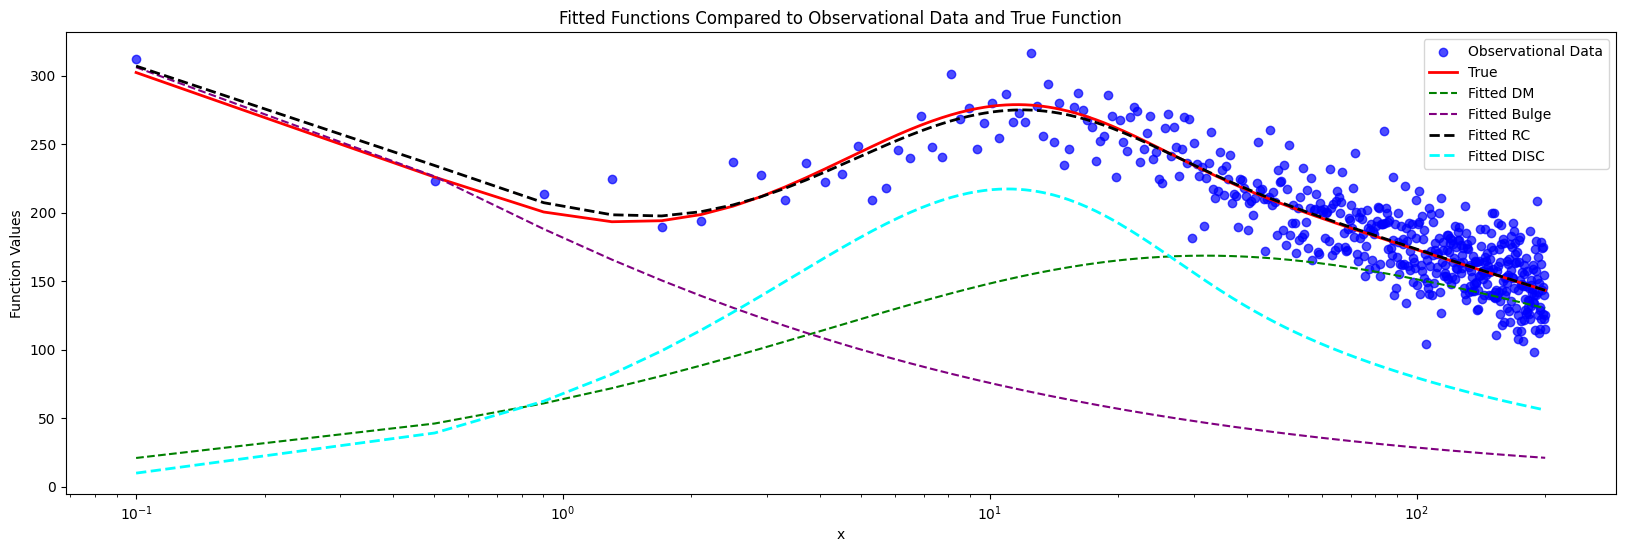

In [153]:
# Extract median values of parameters from MCMC samples
rho_DM_0_mcmc,r_s_mcmc,rho_b0_mcmc,r_b_mcmc,Sigma_0_mcmc, R_d_mcmc  = np.median(flat_samples, axis=0)

# Calculate fitted functions
RC_fit=v_total(x_obs,rho_DM_0_mcmc,r_s_mcmc,rho_b0_mcmc,r_b_mcmc,Sigma_0_mcmc, R_d_mcmc)
DM_fit=v_DM(x_obs,rho_DM_0_mcmc,r_s_mcmc)
BULGE_fit=v_bulge(x_obs,rho_b0_mcmc,r_b_mcmc)
DISC_FIT=v_disk(x_obs,Sigma_0_mcmc, R_d_mcmc)
# Plot the true functions, observational data, and fitted functions
plt.figure(figsize=(20, 6))
plt.scatter(x_obs, y_obs, color="blue", label="Observational Data", alpha=0.7)
plt.plot(x_obs, y_true, color="red", label="True ", linewidth=2)
plt.plot(x_obs, DM_fit, color="green", linestyle="--", label="Fitted DM")
plt.plot(x_obs, BULGE_fit, color="purple", linestyle="--", label="Fitted Bulge")

plt.plot(x_obs, RC_fit, color="black", linestyle="--", label="Fitted RC", linewidth=2)
plt.plot(x_obs, DISC_FIT, color="cyan", linestyle="--", label="Fitted DISC ", linewidth=2)
plt.xlabel("x")
plt.ylabel("Function Values")
plt.title("Fitted Functions Compared to Observational Data and True Function")
plt.xscale("log")
plt.legend()
plt.show()


In [142]:
rho_DM_0_mcmc,r_s_mcmc,rho_b0_mcmc,r_b_mcmc,Sigma_0_mcmc, R_d_mcmc 

(8664427.799075134,
 14.794671432448425,
 5574808027352.531,
 0.032765309302807966,
 184.94843883179846,
 5.122440387741891)